In [29]:
import numpy as np
import pandas as pd
import os

import pickle
from sklearn.linear_model import LogisticRegression
import sklearn.pipeline
from cross_validation import train_models_and_calc_scores_for_n_fold_cv
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to /home/will/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
data_dir='./data_reviews'

# read in training data
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

# create a list of all reviews
x_text_list = x_train_df.values[:,1]
x_text_list = x_text_list.tolist()

tokens = [word_tokenize(review.lower()) for review in x_text_list]

word_2_vec = Word2Vec(tokens, vector_size=100, window=5, min_count=1, workers=4)
print(x_text_list)

['Oh and I forgot to also mention the weird color effect it has on your phone.', "THAT one didn't work either.", 'Waste of 13 bucks.', 'Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.', 'None of the three sizes they sent with the headset would stay in my ears.', 'Worst customer service.', 'The Ngage is still lacking in earbuds.', 'It always cuts out and makes a beep beep beep sound then says signal failed.', 'the only VERY DISAPPOINTING thing was there was NO SPEAKERPHONE!!!!', 'Very disappointed in AccessoryOne.', 'Basically the service was very badly.', 'Bad Choice.', 'The only thing that disappoint me is the infra red port (irda).', 'horrible, had to switch 3 times.', 'It feels poorly constructed, the menus are difficult to navigate, and the buttons are so recessed that it is difficult to push them.', "Don't make the same mistake I did.", "Muddy, low quality sound, and the casing around the wire's insert wa

In [27]:
# takes average of vector for all words in a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

# list of vectors
feature_vectors = [average_word_vectors(review, word_2_vec, word_2_vec.wv.key_to_index, 100) for review in x_text_list]
x_train_matrix = np.stack(feature_vectors)

In [23]:
# export vocabulary
with open('word2vec_model.pkl','wb') as f:
    pickle.dump(word_2_vec,f)

In [30]:

clf = SVC()

# C is hyperparam for regularization
param_grid = {"C": np.logspace(-10,6,17)}

# by default,um folds is 5
search = HalvingGridSearchCV(clf, param_grid,cv=5, random_state=0).fit(x_train_matrix, y_train_df)

/home/will/anaconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/will/anaconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/will/anaconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/will/anaconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vecto

In [31]:
print(search.best_params_)
#print(search.cv_results_['split0_test_score'])
#print(search.cv_results_['params'])

# indices = []
# for index, dict in enumerate(search.cv_results_['params']):
#     if dict['tol'] == search.best_params_['tol']:
#         indices.append(index)

# print(indices)
# for idx in indices:
#     print(search.cv_results_['params'][idx])

#indices = indices[0:17]
# test_scores = []
# train_scores = []
# test_split0, train_split0, test_split1, train_split1, test_split2, train_split2, test_split3, train_split3, test_split4, train_split4 = ([] for i in range(10))
# for idx in indices:
#     test_scores.append(search.cv_results_['mean_test_score'][idx])
#     train_scores.append(search.cv_results_['mean_train_score'][idx])
#     test_split0.append(search.cv_results_['split0_test_score'][idx])
#     train_split0.append(search.cv_results_['split0_train_score'][idx])
#     test_split1.append(search.cv_results_['split1_test_score'][idx])
#     train_split1.append(search.cv_results_['split1_train_score'][idx])
#     test_split2.append(search.cv_results_['split2_test_score'][idx])
#     train_split2.append(search.cv_results_['split2_train_score'][idx])
#     test_split3.append(search.cv_results_['split3_test_score'][idx])
#     train_split3.append(search.cv_results_['split3_train_score'][idx])
#     test_split4.append(search.cv_results_['split4_test_score'][idx])
#     train_split4.append(search.cv_results_['split4_train_score'][idx])

# print(test_scores)
# print(train_scores)

{'C': 10000.0}


In [34]:
model = SVC(C=search.best_params_['C'], probability=True)
y_train_labels = y_train_df
model.fit(x_train_matrix, y_train_labels.values.ravel())

# save classifiers to pkl files
with open('prob2model.pkl','wb') as f:
    pickle.dump(model,f)

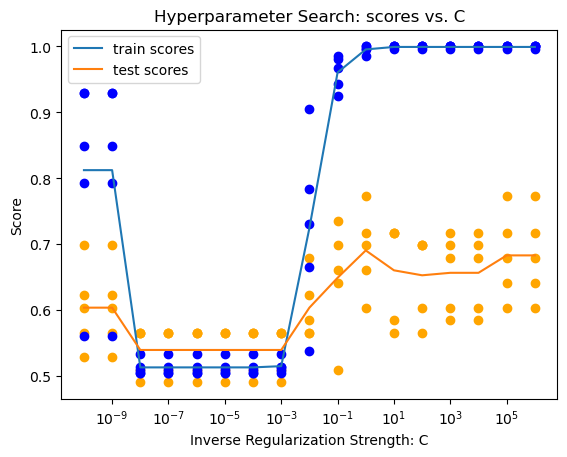

In [81]:
x =  np.logspace(-10,6,17)
plt.plot(x, train_scores, label="train scores")
plt.plot(x, test_scores, label="test scores")
plt.scatter(x, test_split0, color="orange")
plt.scatter(x, test_split1, color="orange")
plt.scatter(x, test_split2, color="orange")
plt.scatter(x, test_split3, color="orange")
plt.scatter(x, test_split4, color="orange")
plt.scatter(x, train_split0, color="blue")
plt.scatter(x, train_split1, color="blue")
plt.scatter(x, train_split2, color="blue")
plt.scatter(x, train_split3, color="blue")
plt.scatter(x, train_split4, color="blue")
plt.legend()
plt.title("Hyperparameter Search: scores vs. C")
plt.xlabel("Inverse Regularization Strength: C")
plt.ylabel("Score")
plt.xscale('log')
plt.show()

In [82]:
# train logistic regression with the selected best params
classifier = LogisticRegression(C=search.best_params_["C"], tol=search.best_params_["tol"], solver=search.best_params_["solver"]) 
classifier.fit(x_train_NV, y_train_df.values.ravel())

# save classifiers to pkl files
with open('testing.pkl','wb') as f:
    pickle.dump(classifier,f)

In [83]:

y_train_df = np.array(y_train_df)
y_train_df.shape
y_train_df = y_train_df.reshape((2400,))
print(y_train_df.shape)

(2400,)


In [84]:
print(x_train_df.to_numpy().shape)
print(x_train_NV.shape)

(2400, 2)
(2400, 4255)


In [85]:
K = 5
        
cv_train_err_list = []
cv_valid_err_list = []
# pipeline = sklearn.pipeline.Pipeline(
#     steps = [('Log regr', LogisticRegression(C= 1e-10, penalty='l1', tol=1e-7))])

#y_train_df = np.array(y_train_df)
length = 2400
split = 0.8
split_spot = 1920
rand_indicies = np.random.permutation(length)
x_train_array = x_train_df.to_numpy()
x_train_text = x_train_array[rand_indicies]
x_train_NV = x_train_NV[rand_indicies]
y_train_df = y_train_df[rand_indicies]

x_train_split = x_train_NV[0:split_spot]
y_train_split = y_train_df[0:split_spot]
x_test_split = x_train_NV[split_spot:2400]
y_test_split = y_train_df[split_spot:2400]

pipeline = LogisticRegression(C= 0.1, penalty='l2', tol=1e-5)

pipeline.fit(x_train_split, y_train_split)

preds = pipeline.predict(x_test_split)
y_proba_preds = pipeline.predict_proba(x_test_split)

In [86]:
false_positives = np.intersect1d(np.where(preds == 1)[0], np.where(y_test_split == 0)[0]) + 1920
false_negatives = np.intersect1d(np.where(preds == 0)[0], np.where(y_test_split == 1)[0]) + 1920
print(false_negatives)
# print(len(false_positives))
# print(x_train_df.shape)
# for idx in false_negatives:
#     print(x_train_df[idx])
for idx in false_negatives:
    print(x_train_text[idx])
    print(y_train_df[idx])
    print(preds[idx - 1920])

[1932 1941 1943 1944 1951 1963 1965 1968 1971 1981 1983 1988 1992 1994
 2010 2014 2017 2024 2035 2051 2054 2064 2066 2067 2069 2071 2073 2075
 2081 2092 2100 2101 2105 2108 2118 2127 2132 2140 2141 2147 2165 2168
 2169 2172 2173 2174 2182 2197 2205 2213 2215 2222 2241 2250 2251 2255
 2261 2269 2290 2297 2299 2301 2321 2336 2337 2345 2347 2348 2360 2382
 2386 2390 2393 2395 2397]
['amazon'
 'I really like this product over the Motorola because it is allot clearer on the ear piece and the mic.']
1
0
['amazon'
 'This little device has transformed my organizational capability and made my life a whole lot easier.']
1
0
['amazon'
 'its a little geeky but i think thats its sex on toast and it rocks and oozes sex right down to its battery embedded sleek stylish leather case.']
1
0
['imdb'
 "This is a witty and delightful adaptation of the Dr Seuss book, brilliantly animated by UPA's finest and thoroughly deserving of its Academy Award.  "]
1
0
['imdb' "You won't forget this movie!  "]
1
0
['am

In [87]:
# print(len(false_positives))
# print(x_train_df.shape)
# for idx in false_negatives:
#     print(x_train_df[idx])
for idx in false_positives:
    print(x_train_text[idx])

['yelp' 'Soggy and not nice.']
['amazon'
 'When I placed my treo into the case, not only was it NOT snug, but there was A LOT of extra room on the sides.']
['yelp'
 'seems like a nice quick place to grab a bite of some familiar pub food, but do yourself a favor and look elsewhere.']
['imdb'
 'This is probably one of the least effective and utterly unoriginal films I have ever seen in my entire life.  ']
['amazon'
 'The camera, although rated at an impressive 1.3 megapixels, renders images that fall well below expectations of such a relatively high resolution.']
['amazon' 'Not nice enough for the price.']
['yelp'
 'Best of luck to the rude and non-customer service focused new management.']
['yelp'
 'Seafood was limited to boiled shrimp and crab legs but the crab legs definitely did not taste fresh.']
['imdb' 'It is not nice.  ']
['yelp'
 "I go to far too many places and I've never seen any restaurant that serves a 1 egg breakfast, especially for $4.00."]
['yelp' "I'm super pissd."]
['im

In [96]:
# compute AUROC score
auroc_score = roc_auc_score( y_test_split, y_proba_preds[:,1]) 
print(auroc_score)

0.8627563334548801


In [88]:
print(cv_train_err_list)
print(cv_valid_err_list)
# for C= 1e-10, penalty='l2', tol=1e-7
#   train_err = 0.43073043
#   valid_err = 0.52891713
# for C= 1e6, penalty='l2', tol=1e-7
#   train_err = 0.07053015
#   valid_err = 0.48599428
# for C= 1, penalty='l2', tol=1e-3
#   train_err = 0.19003116
#   valid_err = 0.44722232
# for C= 10-5, penalty='l2', tol=1e-1
#   train_err = 0.12028722
#   valid_err = 0.4509112

[]
[]
